In [ ]:
import numpy as np
import pandas as pd
import itertools
import warnings
warnings.filterwarnings(action='ignore')

from tqdm.notebook import tqdm

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파이프라인 로드

In [ ]:
from sklearn.base import BaseEstimator 
from sklearn.base import TransformerMixin 

# 행을 드랍하는 파이프라인 변환기
class DropData(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()

        idx = []
        drop_data = X_copy.drop_duplicates(['측정소명', '년/월']).groupby('측정소명').count().수소이온농도.sort_values()[:112]
        for i in range(len(X_copy)):
            if X_copy.iloc[i, :].측정소명 in drop_data:
                idx.append(i)
        X_copy = X_copy.reset_index(drop=True).drop(idx, axis=0)

        X_copy = X_copy.drop_duplicates(['측정소명', '년/월'])
        
        return X_copy


# 날짜형식으로 변환하여 컬럼에 추가하는 파이프라인 변환기
class ConvertDate(BaseEstimator, TransformerMixin):
    def __init__(self, index = False):
        self.index = index

    def fit(self, X, y=None):
        self.date = pd.to_datetime(X['년/월'])
        return self
    def transform(self, X, y=None):
        if self.index:
            X['년/월'] = self.date
            X.set_index('년/월', inplace=True)
            return X
        else :
            X['년/월'] = self.date
            return X

# 이름을 재지정하는 파이프라인 변환기
class RenameAttrs(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.columns = [
                '번호','측정소명', '년/월', '회차', '수심',
                'ph',	'DO',	'BOD',	'COD',	'부유물질',
                'TN',	'TP',	'TOC',	'수온',	'페놀류',
                '전기전도도', '총대장균군수', '카드뮴',	'시안',	'납',
                '6가크롬',	'비소',	'수은',	'구리',	'아연',
                '크롬',	'니켈',	'바륨',	'셀레늄', '용존총질소',
                '암모니아성 질소',	'질산성 질소',	'용존총인',	'인산염인',	'클로로필 a',
                '헥사클로로벤젠',	'분원성대장균군수',	'불소',	'색도',	'노말헥산추출물질',
                '용해성망간',	'용해성철',	'음이온계면활성제',	'트리클로로에틸렌',	'테트라클로로에틸렌',
                '사염화탄소',	'1.2-디클로로에탄',	'디클로로메탄',	'벤젠',	'폴리크로리네이티트비페닐',
                '유기인', '안티몬',	'클로로포름',	'디에틸헥실프탈레이트',	'1.4-다이옥세인',
                '투명도',	'유량',	'포름알데히드', '지역'
                ]
        return self
    def transform(self, X, y=None):
        X.columns = self.columns
        return X

# 컬럼을 드랍하는 파이프라인 변환기
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, drop_list = ['번호']): # nor *args, **kargs
        self.drop_list = drop_list
    
    def fit(self, X, y=None):
        return self # Nothing else to do
    def transform(self, X, y=None):
        X = X.drop(labels=self.drop_list, axis=1)
        return X


# '정량한계미만'인 오브젝트타입 컬럼을 실수형 컬럼으로 변환하는 파이프라인 변환기
class ConvertObject(BaseEstimator, TransformerMixin):
    def __init__(self, convert_list=None, to=0, astype='float'):
        self.convert_list = convert_list
        self.to = 0
        self.astype = astype
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for obj in self.convert_list:
            X[obj][X[obj] == '정량한계미만'] = self.to
            X[obj] = X[obj].astype(self.astype)
        return X


# 절댓값으로 변환
class ConvertAbsolute(BaseEstimator, TransformerMixin):
    def __init__(self, absolute_list=None):
        self.absolute_list = absolute_list
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col in self.absolute_list:
            X[col] = np.absolute(X[col])
        return X

In [ ]:
from sklearn.base import BaseEstimator 
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# ph의 범위를 0~14로 변환
class LimitScope(BaseEstimator, TransformerMixin):
    def __init__(self, limit_dict={'ph':(0, 14)}):
        self.limit_dict = limit_dict
    
    def fit(self, X, y=None):
        self.keys = self.limit_dict.keys()
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()

        for key in self.keys:
            min_condition = X_copy[key] < self.limit_dict[key][0]
            X_copy[key][min_condition] = self.limit_dict[key][0]

            max_condition = X_copy[key] > self.limit_dict[key][1]
            X_copy[key][max_condition] = self.limit_dict[key][1]
        return X_copy

# 박스칵스 변환
class BoxCox(BaseEstimator, TransformerMixin):
    def __init__(self, BC_list=None, epsilon=1e-6):
        self.BC_list = BC_list
        self.epsilon = epsilon
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col in self.BC_list:
            if X[col].min() == 0:
                X[col].loc[X[col] == 0] = self.epsilon

            pt = PowerTransformer(method='box-cox', standardize=False)
            temp = pt.fit_transform(X[col].values.reshape(-1,1))
            X[col] = temp
        return X

# 정규화
class Standardize(BaseEstimator, TransformerMixin):
    def __init__(self, STD_list=None):
        self.STD_list = STD_list
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col in self.STD_list:
            ss = StandardScaler(with_mean=True, with_std=True)
            temp = ss.fit_transform(X[col].values.reshape(-1,1))
            X[col] = temp
        return X


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

class Transform_ETImputation_InverseTransform(BaseEstimator, TransformerMixin):
    def __init__(self, BC_list=None, epsilon=1e-6):
        self.BC_list = BC_list
        self.epsilon = epsilon
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X_original, y=None):
        X = X_original.copy()


        ## LimitScope
        X = LimitScope().fit_transform(X)




        ## BoxCox
        transform_dict = {}

        for col in self.BC_list:
            if X[col].min() == 0:
                X[col].loc[X[col] == 0] = self.epsilon
            transform_dict[col] = PowerTransformer(method='box-cox', standardize=False)
            temp = transform_dict[col].fit_transform(X[col].values.reshape(-1,1))
            X[col] = temp




        # ETImputation
        ET = IterativeImputer(random_state=42,
                              estimator=ExtraTreesRegressor(n_estimators=30,
                                                            min_impurity_decrease=0.01,
                                                            n_jobs=-1,
                                                            random_state=42))   
        temp = ET.fit_transform(X.iloc[:, 2:-1])
        temp = pd.DataFrame(temp)
        temp['측정소명'] = X['측정소명'].values
        temp['측정시'] = X['년/월'].values
        X = temp
        X.columns = ['ph', 'DO', 'BOD', 'COD', '부유물질', 'TN', 'TP', 'TOC', '수온', '총대장균군수',
                     '암모니아성 질소', '클로로필 a','분원성대장균군수', '유량',
                     '측정소명', '측정시']
        



        # InverseTransform
        for col in self.BC_list:

            temp = transform_dict[col].inverse_transform(X[col].values.reshape(-1,1))
            X[col] = temp
        


        ## LimitScope
        X = LimitScope().fit_transform(X)
        

        
        return X


In [ ]:
from sklearn.pipeline import Pipeline

# basic list
drop_list = [
             '번호', '회차', '구리', '아연', '크롬',
             '니켈', '바륨', '셀레늄', '헥사클로로벤젠', '불소',
             '색도', '노말헥산추출물질', '용해성망간', '용해성철', '트리클로로에틸렌',
             '테트라클로로에틸렌', '사염화탄소', '1.2-디클로로에탄', '디클로로메탄', '벤젠',
             '폴리크로리네이티트비페닐', '유기인', '클로로포름', '디에틸헥실프탈레이트', '1.4-다이옥세인',
             '투명도', '포름알데히드','용존총인','용존총질소', '인산염인', '전기전도도', '질산성 질소', 
             '페놀류', '카드뮴', '시안', '납', '6가크롬', '비소', '수은', '수심', '음이온계면활성제', '안티몬'
             ]
convert_list = ['TP', '암모니아성 질소']
absolute_list = ['유량']


basic_pipeline = Pipeline([
                           ('DropData', DropData()),
                           ('ConvertDate', ConvertDate()),
                           ('Rename', RenameAttrs()),
                           ('DropColumns', DropColumns(drop_list=drop_list)),
                           ('ConvertObject', ConvertObject(convert_list=convert_list)),
                           ('ConvertAbsolute', ConvertAbsolute(absolute_list=absolute_list))
])

In [ ]:
# transform
BC_list = ['DO', 'BOD', 'COD', '부유물질', 'TN', 'TP', 'TOC', '총대장균군수', '암모니아성 질소', '클로로필 a', '분원성대장균군수', '유량']
STD_list = ['ph', 'DO', 'BOD', 'COD', '부유물질', 'TN', 'TP', 'TOC', '총대장균군수', '암모니아성 질소', '클로로필 a', '분원성대장균군수', '유량']

transform_pipeline = Pipeline([
                               ('LimitScope', LimitScope()),
                               ('box-cox', BoxCox(BC_list=BC_list)),
                               ('Standadize', Standardize(STD_list=STD_list))
])

# 데이터 로드

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

path = '/content/drive/MyDrive/my_data/water/'
data = pd.read_csv(path + 'water_data.csv')
data = basic_pipeline.fit_transform(data)
data.reset_index(drop=True, inplace=True)
# prep_data = transform_pipeline.fit_transform(data)

In [ ]:
data.수온[data['수온'] == 235.5] = 23.5

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

prep = Transform_ETImputation_InverseTransform(BC_list=BC_list).fit_transform(data)
prep

,ph,DO,BOD,COD,부유물질,TN,TP,TOC,수온,총대장균군수,암모니아성 질소,클로로필 a,분원성대장균군수,유량,측정소명,측정시
0,8.2,12.5,0.2,1.4,0.8,4.898,0.006,0.5,7.5,22.000000,0.072000,0.200000,5.000000e+00,1.798252,충북-가대천,2017-01-04
1,8.4,12.8,0.6,1.4,1.1,4.495,0.007,1.4,4.2,49.000000,0.036000,2.100000,1.100000e+01,1.816038,충북-가대천,2017-02-01
2,8.2,13.5,0.7,2.0,1.3,4.091,0.009,0.8,10.1,23.000000,0.067000,1.700000,1.000000e-06,2.308051,충북-가대천,2017-03-07
3,8.1,10.7,0.9,2.0,3.6,3.359,0.010,0.9,18.8,80.000000,0.022000,1.200000,2.000000e+01,2.294918,충북-가대천,2017-04-04
4,8.1,10.5,0.8,1.8,2.8,3.685,0.029,0.7,25.4,23.000000,0.050000,0.800000,1.000000e-06,2.857955,충북-가대천,2017-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105046,7.9,9.5,1.3,5.6,5.5,2.160,0.034,3.1,18.0,4600.000000,0.045000,23.900000,2.300000e+03,50.285000,세종-청원-1,2021-06-29
105047,7.7,8.9,2.3,8.2,31.2,1.736,0.114,5.1,25.5,1712.184839,0.125000,11.900000,1.485716e+02,0.679000,세종-대교천2,2021-06-30
105048,8.2,10.4,2.7,7.9,19.2,2.382,0.076,5.1,23.1,8752.126422,0.081775,20.494488,8.740974e+02,94.358000,세종-세종2,2021-06-30
105049,7.8,10.8,0.6,4.8,3.9,0.744,0.020,2.7,24.3,365.571399,0.021000,5.700000,1.347611e+01,0.669000,세종-용수천,2021-06-30


In [ ]:
prep

,ph,DO,BOD,COD,부유물질,TN,TP,TOC,수온,총대장균군수,암모니아성 질소,클로로필 a,분원성대장균군수,유량,측정소명,측정시
0,8.2,12.5,0.2,1.4,0.8,4.898,0.006,0.5,7.5,22.000000,0.072000,0.200000,5.000000e+00,1.798252,충북-가대천,2017-01-04
1,8.4,12.8,0.6,1.4,1.1,4.495,0.007,1.4,4.2,49.000000,0.036000,2.100000,1.100000e+01,1.816038,충북-가대천,2017-02-01
2,8.2,13.5,0.7,2.0,1.3,4.091,0.009,0.8,10.1,23.000000,0.067000,1.700000,1.000000e-06,2.308051,충북-가대천,2017-03-07
3,8.1,10.7,0.9,2.0,3.6,3.359,0.010,0.9,18.8,80.000000,0.022000,1.200000,2.000000e+01,2.294918,충북-가대천,2017-04-04
4,8.1,10.5,0.8,1.8,2.8,3.685,0.029,0.7,25.4,23.000000,0.050000,0.800000,1.000000e-06,2.857955,충북-가대천,2017-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105046,7.9,9.5,1.3,5.6,5.5,2.160,0.034,3.1,18.0,4600.000000,0.045000,23.900000,2.300000e+03,50.285000,세종-청원-1,2021-06-29
105047,7.7,8.9,2.3,8.2,31.2,1.736,0.114,5.1,25.5,1712.184839,0.125000,11.900000,1.485716e+02,0.679000,세종-대교천2,2021-06-30
105048,8.2,10.4,2.7,7.9,19.2,2.382,0.076,5.1,23.1,8752.126422,0.081775,20.494488,8.740974e+02,94.358000,세종-세종2,2021-06-30
105049,7.8,10.8,0.6,4.8,3.9,0.744,0.020,2.7,24.3,365.571399,0.021000,5.700000,1.347611e+01,0.669000,세종-용수천,2021-06-30


In [ ]:
data

,측정소명,년/월,ph,DO,BOD,COD,부유물질,TN,TP,TOC,수온,총대장균군수,암모니아성 질소,클로로필 a,분원성대장균군수,유량,지역
0,충북-가대천,2017-01-04,8.2,12.5,0.2,1.4,0.8,4.898,0.006,0.5,7.5,22.0,0.072,0.2,5.0,NaN,충북
1,충북-가대천,2017-02-01,8.4,12.8,0.6,1.4,1.1,4.495,0.007,1.4,4.2,49.0,0.036,2.1,11.0,NaN,충북
2,충북-가대천,2017-03-07,8.2,13.5,0.7,2.0,1.3,4.091,0.009,0.8,10.1,23.0,0.067,1.7,0.0,NaN,충북
3,충북-가대천,2017-04-04,8.1,10.7,0.9,2.0,3.6,3.359,0.010,0.9,18.8,80.0,0.022,1.2,20.0,NaN,충북
4,충북-가대천,2017-05-01,8.1,10.5,0.8,1.8,2.8,3.685,0.029,0.7,25.4,23.0,0.050,0.8,0.0,NaN,충북
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105046,세종-청원-1,2021-06-29,7.9,9.5,1.3,5.6,5.5,2.160,0.034,3.1,18.0,4600.0,0.045,23.9,2300.0,50.285,세종
105047,세종-대교천2,2021-06-30,7.7,8.9,2.3,8.2,31.2,1.736,0.114,5.1,25.5,NaN,0.125,11.9,NaN,0.679,세종
105048,세종-세종2,2021-06-30,8.2,10.4,2.7,7.9,19.2,2.382,0.076,5.1,23.1,NaN,NaN,NaN,NaN,94.358,세종
105049,세종-용수천,2021-06-30,7.8,10.8,0.6,4.8,3.9,0.744,0.020,2.7,24.3,NaN,0.021,5.7,NaN,0.669,세종


# 그래프

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# ETImputation
ET = IterativeImputer(random_state=42,
                      estimator=ExtraTreesRegressor(n_estimators=30,
                                                    min_impurity_decrease=0.01,
                                                    n_jobs=-1,
                                                    random_state=42))   
temp = ET.fit_transform(data.iloc[:, 2:-1])
temp = pd.DataFrame(temp)
temp['측정소명'] = data['측정소명'].values
temp['측정시'] = data['년/월'].values
X = temp
X.columns = ['ph', 'DO', 'BOD', 'COD', '부유물질', 'TN', 'TP', 'TOC', '수온', '총대장균군수',
             '암모니아성 질소', '클로로필 a','분원성대장균군수', '유량',
             '측정소명', '측정시']

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


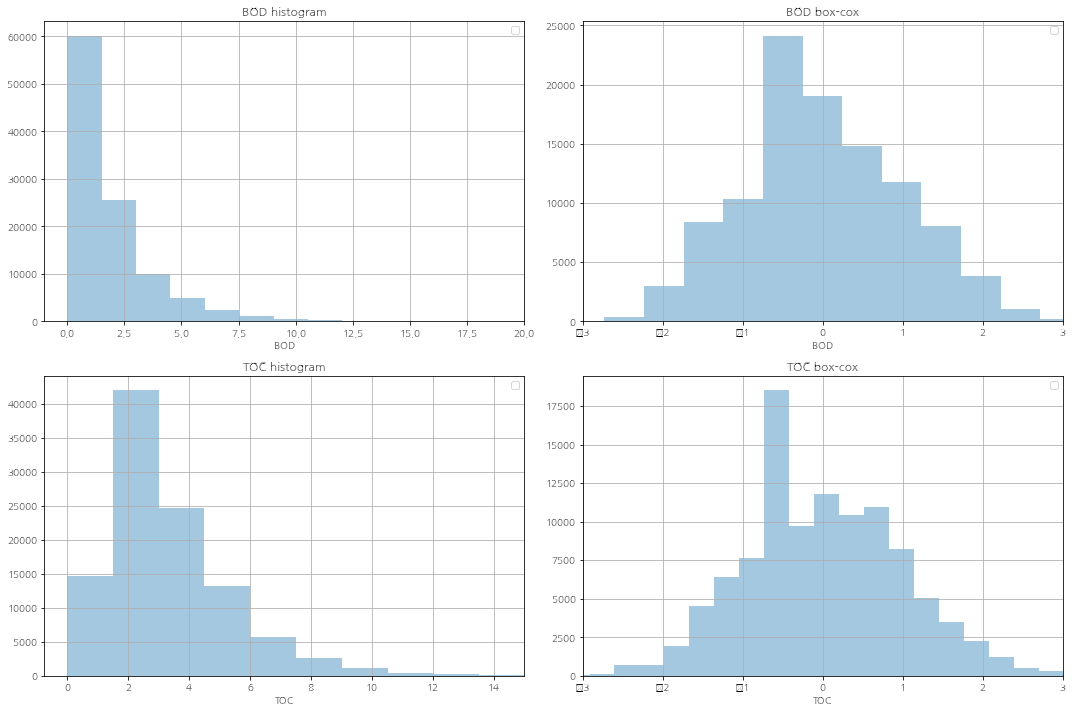

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import power_transform

fig = plt.figure(figsize=(15, 10))

ax1=plt.subplot(221)
sns.distplot(prep['BOD'], kde=False)
plt.xlim((-1, 20))
plt.title('BOD histogram')
plt.xlabel('BOD')
plt.ylabel('')
plt.legend(loc='upper right')
plt.grid()

ax2=plt.subplot(222)
temp = PowerTransformer(method='box-cox', standardize=True).fit_transform(prep['BOD'].values.reshape(-1,1))
sns.distplot(temp, kde=False)
plt.xlim((-3, 3))
plt.title('BOD box-cox')
plt.xlabel('BOD')
plt.legend()
plt.grid()

ax3=plt.subplot(223)
sns.distplot(prep['TOC'], kde=False)
plt.xlim((-0.75, 15))
plt.title('TOC histogram')
plt.xlabel('TOC')
plt.ylabel('')
plt.legend(loc='upper right')
plt.grid()

ax4=plt.subplot(224)
temp = PowerTransformer(method='box-cox', standardize=True).fit_transform(prep['TOC'].values.reshape(-1,1))
sns.distplot(temp, kde=False)
plt.xlim((-3, 3))
plt.title('TOC box-cox')
plt.xlabel('TOC')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(path + '일반 vs 변환')
plt.show()

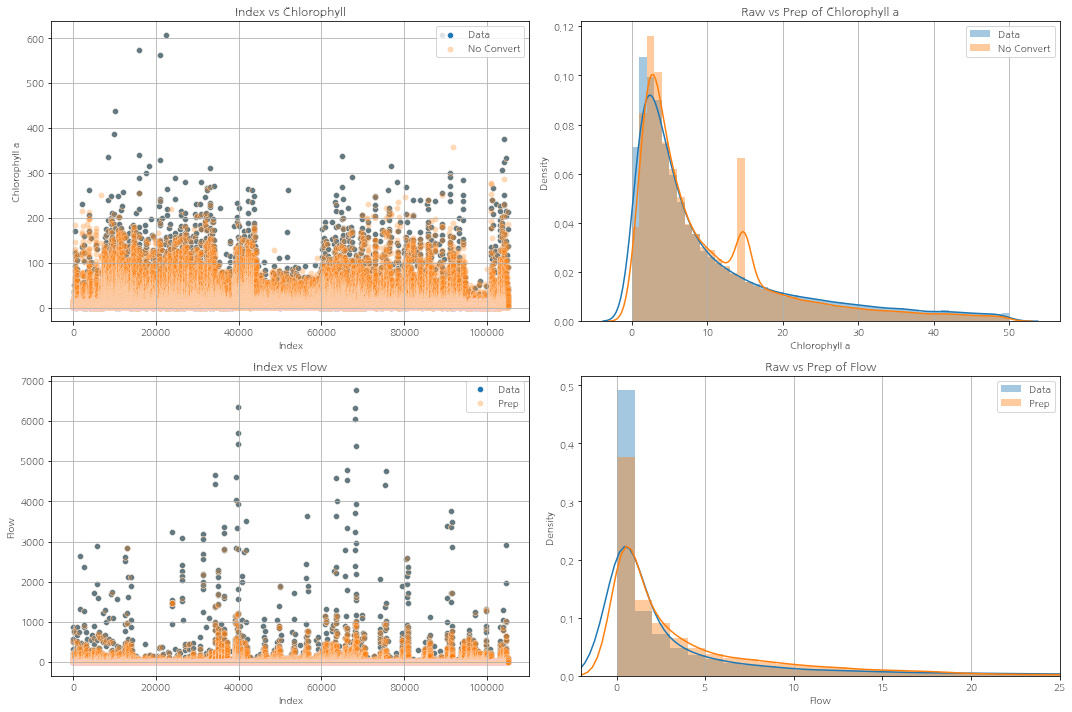

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
sns.scatterplot(data.index, data['클로로필 a'], alpha=1, label = 'Data')
sns.scatterplot(X.index, X['클로로필 a'], alpha=0.3, label = 'No Convert')
plt.title('Index vs Chlorophyll')
plt.xlabel('Index')
plt.ylabel('Chlorophyll a')
plt.legend(loc='upper right')
plt.grid()


ax2=plt.subplot(222)
sns.distplot(data['클로로필 a'].loc[data['클로로필 a'] <= 50], label = 'Data')
sns.distplot(X['클로로필 a'].loc[X['클로로필 a'] <= 50], label = 'No Convert')
plt.title('Raw vs Prep of Chlorophyll a')
plt.xlabel('Chlorophyll a')
plt.legend()
plt.grid(axis='x')

ax3=plt.subplot(223)
sns.scatterplot(data.index, data['유량'], alpha=1, label = 'Data')
sns.scatterplot(prep.index, prep['유량'], alpha=0.3, label = 'Prep')
plt.title('Index vs Flow')
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.grid()


ax4=plt.subplot(224)
sns.distplot(data['유량'].loc[data['유량'] <= 50], label = 'Data')
sns.distplot(prep['유량'].loc[prep['유량'] <= 50], label = 'Prep')
plt.xlim((-2,25))
plt.title('Raw vs Prep of Flow')
plt.xlabel('Flow')
plt.legend()
plt.grid(axis='x')

plt.tight_layout()
plt.savefig(path + 'Raw vs NoConvert ExtraTree')
plt.show()

# Labeling

In [ ]:
# 판별 함수 준비
# 1로 갈수록 좋음 5로 갈수록 안좋음

def ph(row):
    if 8.5 >= row['ph'] >= 6.5: result = 1
    else : result = 5
    return result

def BOD(row):
    if   row['BOD'] > 10: result = 5
    elif row['BOD'] > 5: result = 4
    elif row['BOD'] > 3: result = 3
    elif row['BOD'] > 1: result = 2
    else : result = 1
    return result

def COD(row):
    if   row['COD'] > 11: result = 5
    elif row['COD'] > 7: result = 4
    elif row['COD'] > 5: result = 3
    elif row['COD'] > 2: result = 2
    else : result = 1
    return result

def DO(row):
    if   row['DO'] < 2: result = 5
    elif row['DO'] < 5: result = 3
    elif row['DO'] < 7.5: result = 2
    else : result = 1
    return result

def TN(row):
    if   row['TN'] > 8: result = 5
    elif row['TN'] > 4: result = 4
    elif row['TN'] > 3: result = 3
    elif row['TN'] > 1.5: result = 2
    else : result = 1
    return result

def TP(row):
    if   row['TP'] > 0.5: result = 5
    elif row['TP'] > 0.2: result = 4
    elif row['TP'] > 0.1: result = 3
    elif row['TP'] > 0.02: result = 2
    else : result = 1
    return result

def TOC(row):
    if   row['TOC'] > 8: result = 5
    elif row['TOC'] > 5: result = 4
    elif row['TOC'] > 4: result = 3
    elif row['TOC'] > 2: result = 2
    else : result = 1
    return result

def 부유물질(row):
    if   row['부유물질'] > 100: result = 5
    elif row['부유물질'] > 25: result = 4
    else : result = 1
    return result

def 총대장균군수(row):
    if   row['총대장균군수'] > 5000: result = 4
    elif row['총대장균군수'] > 1000: result = 3
    elif row['총대장균군수'] > 50: result = 2
    else : result = 1
    return result

def 분원성대장균군수(row):
    if   row['분원성대장균군수'] > 1000: result = 4
    elif row['분원성대장균군수'] > 200: result = 3
    elif row['분원성대장균군수'] > 10: result = 2
    else : result = 1
    return result

def 암모니아성질소(row):
    if   row['암모니아성 질소'] > 0.5: result = 3
    elif row['암모니아성 질소'] > 0.02: result = 2
    else : result = 1
    return result

def 클로로필a(row):
    if   row['클로로필 a'] >= 100 : result = 4
    elif row['클로로필 a'] >= 25 : result = 3
    elif row['클로로필 a'] >= 15 : result = 2
    else : result = 1
    return result

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

X = prep.copy()
X['target'] = np.empty(len(X))
for i in tqdm(range(len(X))):
    row = X.iloc[i]
    target = np.max([ ph(row), BOD(row), COD(row), DO(row), TN(row), TP(row), TOC(row),
                      부유물질(row), 총대장균군수(row), 분원성대장균군수(row),
                      암모니아성질소(row), 클로로필a(row)
                      ])
    X['target'][i] = target

  0%|          | 0/105051 [00:00<?, ?it/s]

In [ ]:
# BoxCox변환 전 데이터
X.to_csv(path + 'Preprocessed_Data.csv')
# 이후 BoxCox 변환 후 ARIMA 예측모델 후 Inverse